# Cal-CRAI Index: Governance Domain

**Order of operations**:
- Metric handling
   - Retrieve data
   - Min-max standardization
   - Set vulnerability orientation (pos for vulnerable, neg for resilience)
- Calculate indicators
   - Min-max standardization
- Calculate domain score
- Visualizations

Note: Functions and figures within this notebook are in development

In [1]:
import pandas as pd
import os
import sys
import warnings

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import plot_domain, plot_region_domain
from scripts.utils.calculate_index import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


In [3]:
# domain-specific
domain_prefix = 'governance_'

input_folder = r'C:/Users/jespi/eagle/carb-climate-index-19/aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'C:/Users/jespi/eagle/carb-climate-index-19/metadata/Full Data Pipeline Notes - 4_ Calculate Metric.csv'
merged_output_file = f'concatenate_{domain_prefix}metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 16 CSV files within governance_domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_governance_metrics.csv


### Take a look at the resulting dictionary
We will use this later to refactor 'resilient' metrics

In [4]:
metric_vulnerable_resilient_dict

{'vulnerable': ['percent_sampled_wells_contaminated'],
 'resilient': ['nfip_participation',
  'total_emergency_management_funding',
  'num_emergency_medical_technicians_and_paramedics_employed_per_10000',
  'num_firefighting_and_prevention_workers_employed_per_10000',
  'num_fire_stations_per_10000_people',
  'num_flood_policies',
  'total_fuel_reduction_acres_planned',
  'total_hazard_mitigation_funding',
  'housing_units_with_mortgage',
  'percent_prepared_for_general_disaster',
  'percent_prepared_without_power',
  'percent_prepared_without_water',
  'num_police_officers_employed_per_10000',
  'num_registered_nurses_employed_per_10000',
  'percent_under_timber_management']}

### Now, take a look at the merged singluar csv file

In [8]:
# read-in and view processed data
processed_governance_df = pd.read_csv('concatenate_governance_metrics.csv')
processed_governance_df

,GEOID,nfip_participation,total_emergency_management_funding,num_emergency_medical_technicians_and_paramedics_employed_per_10000,num_firefighting_and_prevention_workers_employed_per_10000,num_fire_stations_per_10000_people,num_flood_policies,total_fuel_reduction_acres_planned,total_hazard_mitigation_funding,housing_units_with_mortgage,percent_prepared_for_general_disaster,percent_prepared_without_power,percent_prepared_without_water,num_police_officers_employed_per_10000,num_registered_nurses_employed_per_10000,percent_under_timber_management,percent_sampled_wells_contaminated
0,6001400100,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,NaN,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.130130,NaN,NaN
1,6001400200,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,NaN,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.130130,NaN,NaN
2,6001400300,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,NaN,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.130130,NaN,NaN
3,6001400400,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,NaN,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.130130,NaN,NaN
4,6001400500,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,NaN,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.130130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,1.0,1188864.0,3.671746,6.119577,1.468698,586.0,NaN,1.129758e+07,67.5,50.000000,100.000000,100.000000,31.209840,70.987088,0.573947,57.142857
9125,6115041001,1.0,1188864.0,3.671746,6.119577,1.468698,586.0,NaN,1.129758e+07,67.5,50.000000,100.000000,100.000000,31.209840,70.987088,0.573947,83.333333
9126,6115041002,1.0,1188864.0,3.671746,6.119577,1.468698,586.0,NaN,1.129758e+07,67.5,50.000000,100.000000,100.000000,31.209840,70.987088,0.573947,38.888889
9127,6115041101,1.0,1188864.0,3.671746,6.119577,1.468698,586.0,NaN,1.129758e+07,67.5,50.000000,100.000000,100.000000,31.209840,70.987088,0.573947,58.823529


### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [11]:
# standardizing our df
columns_to_process = [col for col in processed_governance_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(processed_governance_df, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [9]:
# this will show the standardized columns as well as their max and min column counterparts used in the process

#min_max_metrics

Isolate for GEOID and standardized columns exclusively

In [12]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_governance_metrics_df = min_max_metrics[selected_columns]

In [13]:
min_max_standardized_governance_metrics_df.head()

,GEOID,nfip_participation_min_max_standardized,total_emergency_management_funding_min_max_standardized,num_emergency_medical_technicians_and_paramedics_employed_per_10000_min_max_standardized,num_firefighting_and_prevention_workers_employed_per_10000_min_max_standardized,num_fire_stations_per_10000_people_min_max_standardized,num_flood_policies_min_max_standardized,total_fuel_reduction_acres_planned_min_max_standardized,total_hazard_mitigation_funding_min_max_standardized,housing_units_with_mortgage_min_max_standardized,percent_prepared_for_general_disaster_min_max_standardized,percent_prepared_without_power_min_max_standardized,percent_prepared_without_water_min_max_standardized,num_police_officers_employed_per_10000_min_max_standardized,num_registered_nurses_employed_per_10000_min_max_standardized,percent_under_timber_management_min_max_standardized,percent_sampled_wells_contaminated_min_max_standardized
0,6001400100,1.0,0.186246,0.186644,0.090217,0.079988,0.13126,NaN,0.235375,0.774038,0.52381,0.571429,0.571429,0.019072,0.170417,NaN,NaN
1,6001400200,1.0,0.186246,0.186644,0.090217,0.079988,0.13126,NaN,0.235375,0.774038,0.52381,0.571429,0.571429,0.019072,0.170417,NaN,NaN
2,6001400300,1.0,0.186246,0.186644,0.090217,0.079988,0.13126,NaN,0.235375,0.774038,0.52381,0.571429,0.571429,0.019072,0.170417,NaN,NaN
3,6001400400,1.0,0.186246,0.186644,0.090217,0.079988,0.13126,NaN,0.235375,0.774038,0.52381,0.571429,0.571429,0.019072,0.170417,NaN,NaN
4,6001400500,1.0,0.186246,0.186644,0.090217,0.079988,0.13126,NaN,0.235375,0.774038,0.52381,0.571429,0.571429,0.019072,0.170417,NaN,NaN


### 1c) Set vulnerability orientation
* High values indicate vulnerability
* Low values indicate resiliency

Some metrics indicate a communities resistance rather than vulnerablity. For example, number of emergency personel per 10,000 people represents a communities ability to respond to emergencies. For this metric, the higher the number, the more resilient. So we identify these 'resilient' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate vulnerability

In [14]:
metric_vulnerable_resilient_dict

{'vulnerable': ['percent_sampled_wells_contaminated'],
 'resilient': ['nfip_participation',
  'total_emergency_management_funding',
  'num_emergency_medical_technicians_and_paramedics_employed_per_10000',
  'num_firefighting_and_prevention_workers_employed_per_10000',
  'num_fire_stations_per_10000_people',
  'num_flood_policies',
  'total_fuel_reduction_acres_planned',
  'total_hazard_mitigation_funding',
  'housing_units_with_mortgage',
  'percent_prepared_for_general_disaster',
  'percent_prepared_without_power',
  'percent_prepared_without_water',
  'num_police_officers_employed_per_10000',
  'num_registered_nurses_employed_per_10000',
  'percent_under_timber_management']}

In [15]:
# Access the resilient column names from the dictionary
resilient_columns = metric_vulnerable_resilient_dict['resilient']

# Identify columns in the DataFrame that contain any of the resilient column names as substrings
resilient_columns_in_df = [col for col in min_max_standardized_governance_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in resilient_columns)]

# Create a new DataFrame with the adjusted resilient columns
adjusted_resilient_df = min_max_standardized_governance_metrics_df.copy()

# Subtract the standardized resilient columns from one and store the result in the new DataFrame
adjusted_resilient_df.loc[:, resilient_columns_in_df] = (
    1 - adjusted_resilient_df.loc[:, resilient_columns_in_df]
)

In [16]:
adjusted_resilient_df

,GEOID,nfip_participation_min_max_standardized,total_emergency_management_funding_min_max_standardized,num_emergency_medical_technicians_and_paramedics_employed_per_10000_min_max_standardized,num_firefighting_and_prevention_workers_employed_per_10000_min_max_standardized,num_fire_stations_per_10000_people_min_max_standardized,num_flood_policies_min_max_standardized,total_fuel_reduction_acres_planned_min_max_standardized,total_hazard_mitigation_funding_min_max_standardized,housing_units_with_mortgage_min_max_standardized,percent_prepared_for_general_disaster_min_max_standardized,percent_prepared_without_power_min_max_standardized,percent_prepared_without_water_min_max_standardized,num_police_officers_employed_per_10000_min_max_standardized,num_registered_nurses_employed_per_10000_min_max_standardized,percent_under_timber_management_min_max_standardized,percent_sampled_wells_contaminated_min_max_standardized
0,6001400100,0.0,0.813754,0.813356,0.909783,0.920012,0.868740,NaN,0.764625,0.225962,0.47619,0.428571,0.428571,0.980928,0.829583,NaN,NaN
1,6001400200,0.0,0.813754,0.813356,0.909783,0.920012,0.868740,NaN,0.764625,0.225962,0.47619,0.428571,0.428571,0.980928,0.829583,NaN,NaN
2,6001400300,0.0,0.813754,0.813356,0.909783,0.920012,0.868740,NaN,0.764625,0.225962,0.47619,0.428571,0.428571,0.980928,0.829583,NaN,NaN
3,6001400400,0.0,0.813754,0.813356,0.909783,0.920012,0.868740,NaN,0.764625,0.225962,0.47619,0.428571,0.428571,0.980928,0.829583,NaN,NaN
4,6001400500,0.0,0.813754,0.813356,0.909783,0.920012,0.868740,NaN,0.764625,0.225962,0.47619,0.428571,0.428571,0.980928,0.829583,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6115040902,0.0,0.962824,0.945580,0.918889,0.500360,0.970886,NaN,0.986371,0.283654,0.50000,0.000000,0.000000,0.761313,0.878163,0.882029,0.571429
9125,6115041001,0.0,0.962824,0.945580,0.918889,0.500360,0.970886,NaN,0.986371,0.283654,0.50000,0.000000,0.000000,0.761313,0.878163,0.882029,0.833333
9126,6115041002,0.0,0.962824,0.945580,0.918889,0.500360,0.970886,NaN,0.986371,0.283654,0.50000,0.000000,0.000000,0.761313,0.878163,0.882029,0.388889
9127,6115041101,0.0,0.962824,0.945580,0.918889,0.500360,0.970886,NaN,0.986371,0.283654,0.50000,0.000000,0.000000,0.761313,0.878163,0.882029,0.588235


## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [17]:
domain_prefix[:-1]

'governance'

In [18]:
averaged_indicators_governance_systems = compute_averaged_indicators(
    adjusted_resilient_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_governance_systems

,GEOID,emergency_response,personal_preparedness,community_preparedness,natural_resource_conservation
0,6001400100,0.890732,0.485607,0.382312,NaN
1,6001400200,0.890732,0.485607,0.382312,NaN
2,6001400300,0.890732,0.485607,0.382312,NaN
3,6001400400,0.890732,0.485607,0.382312,NaN
4,6001400500,0.890732,0.485607,0.382312,NaN
...,...,...,...,...,...
9124,6115040902,0.800861,0.350908,0.493185,NaN
9125,6115041001,0.800861,0.350908,0.493185,NaN
9126,6115041002,0.800861,0.350908,0.493185,NaN
9127,6115041101,0.800861,0.350908,0.493185,NaN


Sum all the non-census tract columns together to calculate the domain score

In [19]:
columns_to_sum = [col for col in averaged_indicators_governance_systems.columns if col != 'GEOID']
summed_indicators_governance_systems = compute_summed_indicators(
    df=averaged_indicators_governance_systems, 
    columns_to_sum=columns_to_sum,
    domain_prefix=domain_prefix
)

Indicator sum min value: 0.0
Indicator sum max value: 2.2664695120638756


### 2a) Min-max standardize the summed columns

In [20]:
columns_to_process = [col for col in summed_indicators_governance_systems.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_governance_systems, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [21]:
min_max_domain

,GEOID,summed_indicators_governance_domain_min,summed_indicators_governance_domain_max,summed_indicators_governance_domain_min_max_standardized
0,6001400100,0.0,2.26647,0.775943
1,6001400200,0.0,2.26647,0.775943
2,6001400300,0.0,2.26647,0.775943
3,6001400400,0.0,2.26647,0.775943
4,6001400500,0.0,2.26647,0.775943
...,...,...,...,...
9124,6115040902,0.0,2.26647,0.725778
9125,6115041001,0.0,2.26647,0.725778
9126,6115041002,0.0,2.26647,0.725778
9127,6115041101,0.0,2.26647,0.725778


Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [22]:
min_max_standardized_governance_systems_domain = min_max_domain[['GEOID', 'summed_indicators_governance_domain_min_max_standardized']].copy()

# GEOID handling
min_max_standardized_governance_systems_domain['GEOID'] = min_max_standardized_governance_systems_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_governance_systems_domain['GEOID'] = min_max_standardized_governance_systems_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

## Step 3: Visualizing the domain


Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)

In [23]:
gdf = add_census_tracts(min_max_standardized_governance_systems_domain)

In [24]:
gdf.columns

Index(['GEOID', 'summed_indicators_governance_domain_min_max_standardized',
       'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

Let's look at some summary statistics for this domain:

In [25]:
domain_summary_stats(gdf, 'summed_indicators_governance_domain_min_max_standardized')

Median summed_indicators_governance_domain_min_max_standardized domain value: 0.787585615259183
Mean summed_indicators_governance_domain_min_max_standardized domain value: 0.7509153420761099


Now let's visualize the entire domain!

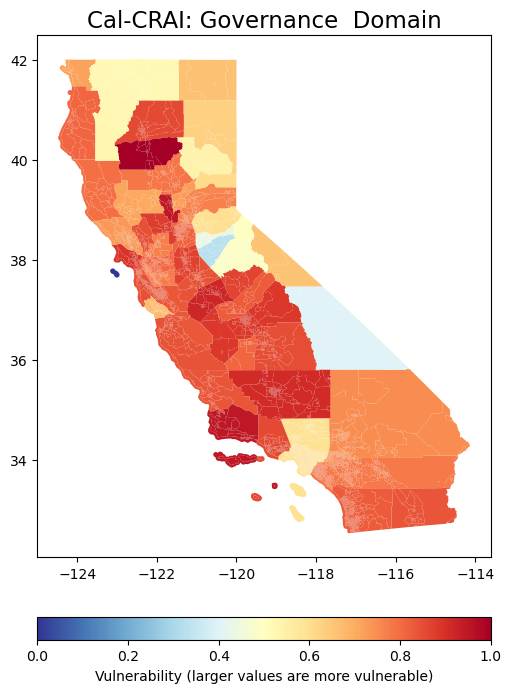

In [26]:
plot_domain(gdf, domain=domain_prefix)

### We can also visualize specific areas!
We call from a the `plot_region_domain` function which has a number of variables:

gdf : GeoDataFrame
    A GeoDataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.

counties_to_plot : list of str, optional
    A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
    Example: ['037', '071', '065', '029', '111'].

region : str, optional
    A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
    If specified, this will override `counties_to_plot`.

plot_all : bool, optional
    If True, plots all counties in California. Overrides `counties_to_plot` and `region`.

savefig : bool, optional
    If True, the plot will be saved as a PNG file. Default is False.

font_color : str, optional
    Color of the font for county labels. Default is 'black'.

domain_name : str, optional
    Name of the domain to include in the plot title. Default is 'Society and Economy Domain'.


    Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels
Below are a few example of each of these plotting scenarios

Number of invalid geometries: 0


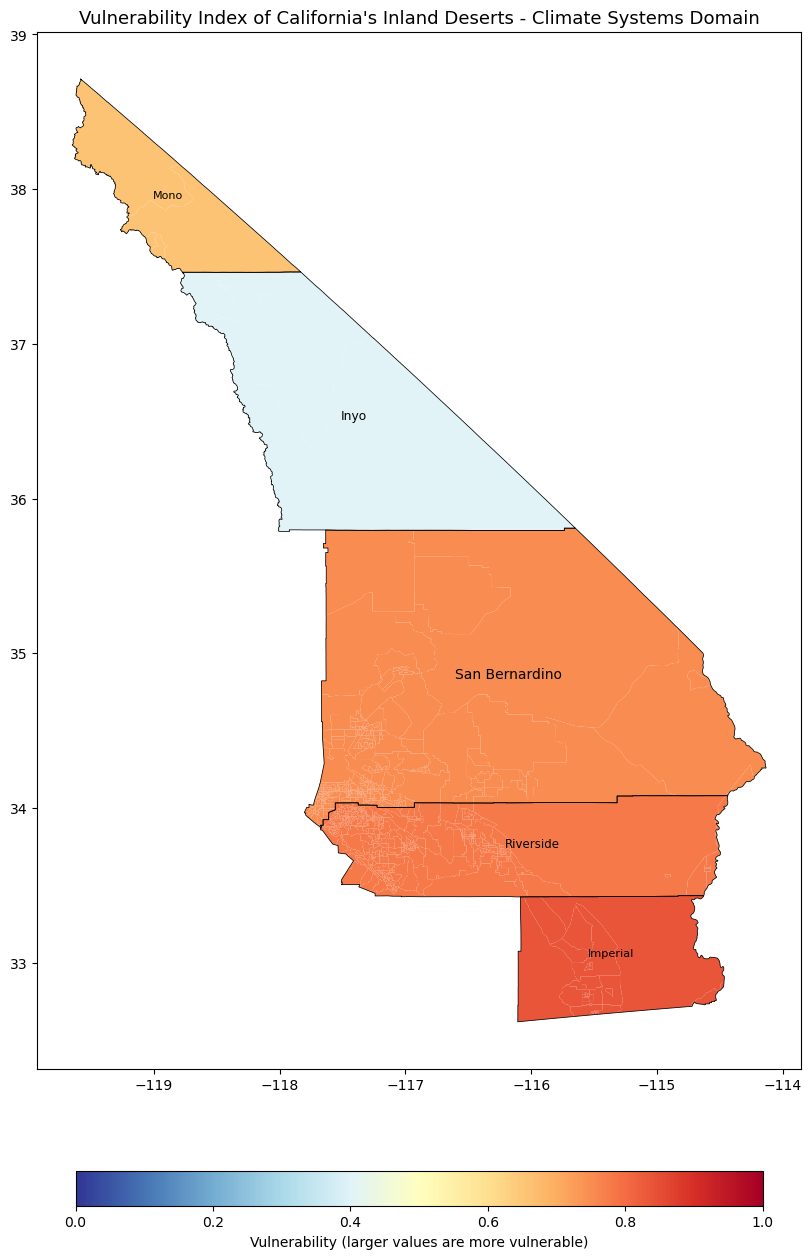

In [29]:
plot_region_domain(min_max_standardized_governance_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Climate Systems Domain'}, region='inland_deserts', savefig=False, font_color='black')

Number of invalid geometries: 0


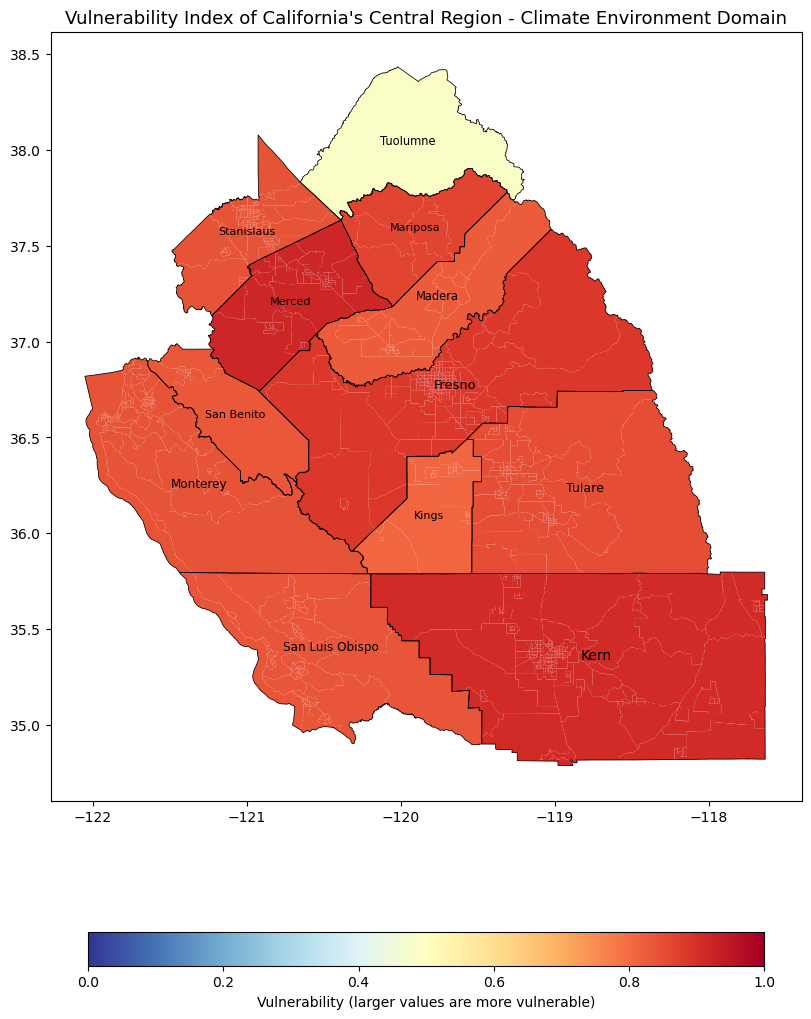

In [30]:
plot_region_domain(min_max_standardized_governance_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Climate Environment Domain'}, region='central_region', savefig=False, font_color='black')

Number of invalid geometries: 0


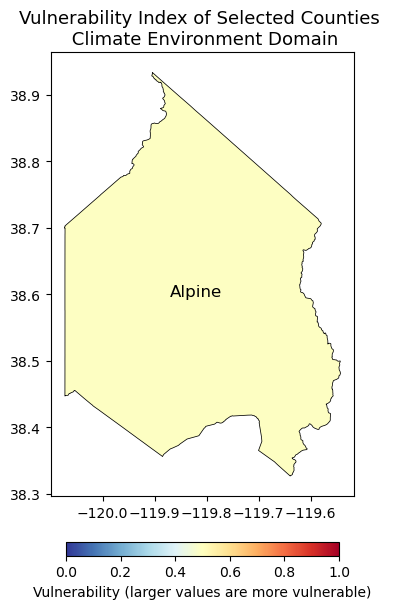

In [31]:
list_of_counties = ['003']
plot_region_domain(min_max_standardized_governance_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Climate Environment Domain'}, counties_to_plot=list_of_counties, savefig=False, font_color='black')

Number of invalid geometries: 0


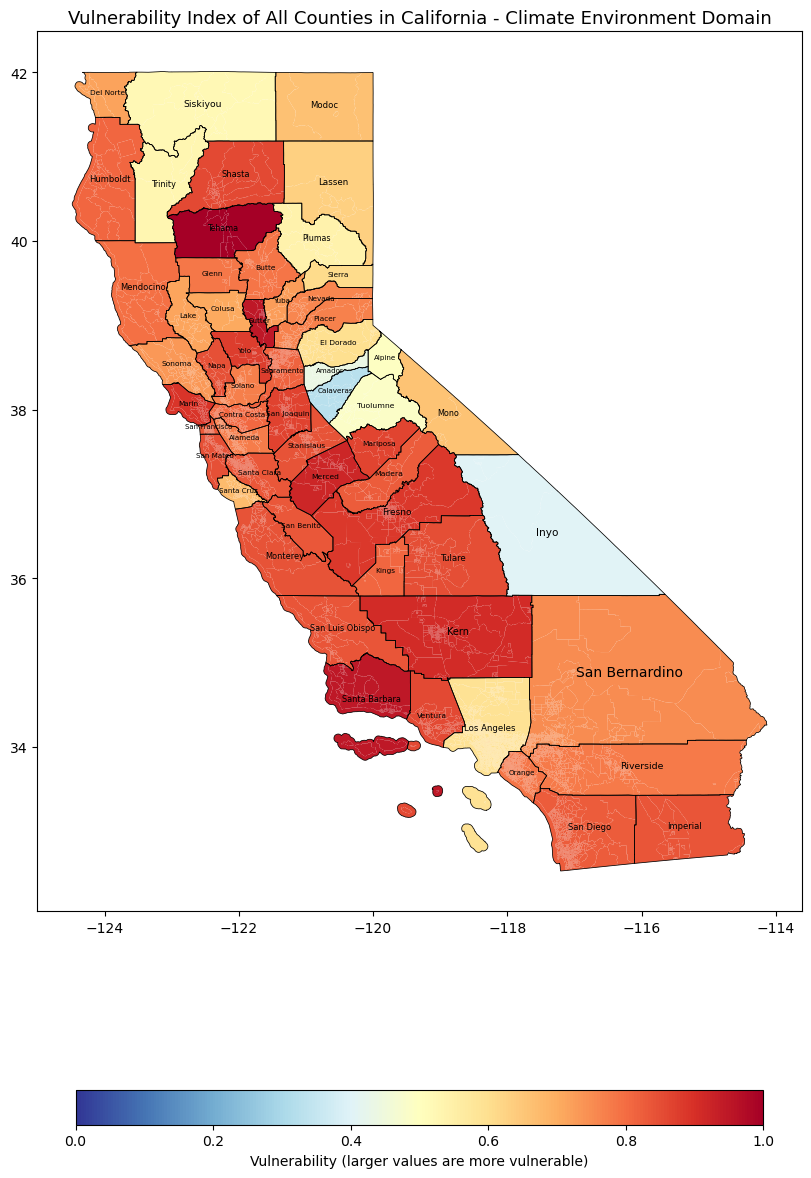

In [32]:
plot_region_domain(min_max_standardized_governance_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Climate Environment Domain'}, plot_all=True, savefig=False, font_color='black')

## Step 4: Export the final domain csv file

In [17]:
# set-up file for export
filename = '{}index_data.csv'.format(domain_prefix)
gdf.to_csv(filename, index=False)

# export to AWS (Cal-CRAI)
directory = '3_fair_data/domain_standardized_data'
upload_csv_aws([filename], bucket_name, directory)